## Tut6 RNN for learning time dependencies
- based on a great tutorial on RNN's:
    - http://r2rt.com/recurrent-neural-networks-in-tensorflow-i.html

In [1]:
import numpy as np
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt

#### Run Parameters

In [2]:
# Global config variables
num_steps = 10 # 5 # number of truncated backprop steps ('n' in the discussion above)
batch_size = 200
num_classes = 2
state_size = 4
learning_rate = 0.1

#### Data Generation

In [3]:
def gen_data(size=1000000):
    X = np.array(np.random.choice(2, size=(size,)))
    Y = []
    for i in range(size):
        threshold = 0.5
        if X[i-3] == 1:
            threshold += 0.5
        if X[i-8] == 1:
            threshold -= 0.25
        if np.random.rand() > threshold:
            Y.append(0)
        else:
            Y.append(1)
    return X, np.array(Y)

# adapted from https://github.com/tensorflow/tensorflow/blob/master/tensorflow/models/rnn/ptb/reader.py
def gen_batch(raw_data, batch_size, num_steps):
    raw_x, raw_y = raw_data
    data_length = len(raw_x)

    # partition raw data into batches and stack them vertically in a data matrix
    batch_partition_length = data_length // batch_size
    data_x = np.zeros([batch_size, batch_partition_length], dtype=np.int32)
    data_y = np.zeros([batch_size, batch_partition_length], dtype=np.int32)
    for i in range(batch_size):
        data_x[i] = raw_x[batch_partition_length * i:batch_partition_length * (i + 1)]
        data_y[i] = raw_y[batch_partition_length * i:batch_partition_length * (i + 1)]
    # further divide batch partitions into num_steps for truncated backprop
    epoch_size = batch_partition_length // num_steps

    for i in range(epoch_size):
        x = data_x[:, i * num_steps:(i + 1) * num_steps]
        y = data_y[:, i * num_steps:(i + 1) * num_steps]
        yield (x, y)

def gen_epochs(n, num_steps, batch_size=200):
    for i in range(n):
        yield gen_batch(gen_data(), batch_size, num_steps)

#### Model

In [4]:
### Placeholders
x = tf.placeholder(tf.int32, [batch_size, num_steps], name='input_placeholder')
y = tf.placeholder(tf.int32, [batch_size, num_steps], name='labels_placeholder')
init_state = tf.zeros([batch_size, state_size])

### Inputs
x_one_hot = tf.one_hot(x, num_classes)
rnn_inputs = tf.unpack(x_one_hot, axis=1)

### RNN
cell = tf.nn.rnn_cell.BasicRNNCell(state_size)
rnn_outputs, final_state = tf.nn.rnn(cell, rnn_inputs, initial_state=init_state)

### Predictions, loss, training step
with tf.variable_scope('softmax'):
    W = tf.get_variable('W', [state_size, num_classes])
    b = tf.get_variable('b', [num_classes], initializer=tf.constant_initializer(0.0))
logits = [tf.matmul(rnn_output, W) + b for rnn_output in rnn_outputs]
predictions = [tf.nn.softmax(logit) for logit in logits]

y_as_list = [tf.squeeze(i, squeeze_dims=[1]) for i in tf.split(1, num_steps, y)]

loss_weights = [tf.ones([batch_size]) for i in range(num_steps)]
losses = tf.nn.seq2seq.sequence_loss_by_example(logits, y_as_list, loss_weights)
total_loss = tf.reduce_mean(losses)
train_step = tf.train.AdagradOptimizer(learning_rate).minimize(total_loss)

#### Training

In [6]:
def train_network(num_epochs, num_steps, state_size=4, verbose=True):
    with tf.Session() as sess:
        sess.run(tf.initialize_all_variables())
        training_losses = []
        for idx, epoch in enumerate(gen_epochs(num_epochs, num_steps)):
            training_loss = 0
            training_state = np.zeros((batch_size, state_size))
            if verbose:
                print("\nEPOCH", idx)
            for step, (X, Y) in enumerate(epoch):
                tr_losses, training_loss_, training_state, _ = \
                    sess.run([losses,
                              total_loss,
                              final_state,
                              train_step],
                                  feed_dict={x:X, y:Y, init_state:training_state})
                training_loss += training_loss_
                if step % 100 == 0 and step > 0:
                    if verbose:
                        print("Average loss at step", step,
                              "for last 250 steps:", training_loss/100)
                    training_losses.append(training_loss/100)
                    training_loss = 0
    return training_losses


EPOCH 0
Average loss at step 100 for last 250 steps: 0.656728538871
Average loss at step 200 for last 250 steps: 0.63956230104
Average loss at step 300 for last 250 steps: 0.638824413419
Average loss at step 400 for last 250 steps: 0.636326394081
Average loss at step 500 for last 250 steps: 0.632813531756
Average loss at step 600 for last 250 steps: 0.625706725717
Average loss at step 700 for last 250 steps: 0.624775794744
Average loss at step 800 for last 250 steps: 0.62596557498
Average loss at step 900 for last 250 steps: 0.591862223148


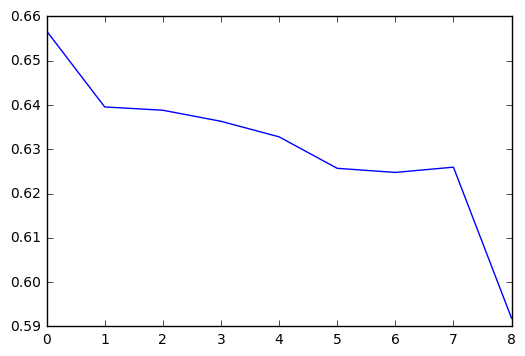

In [7]:
training_losses = train_network(1, num_steps)
plt.plot(training_losses)


EPOCH 0
Average loss at step 100 for last 250 steps: 0.572779156566
Average loss at step 200 for last 250 steps: 0.519772151113
Average loss at step 300 for last 250 steps: 0.519941653013
Average loss at step 400 for last 250 steps: 0.520407815576


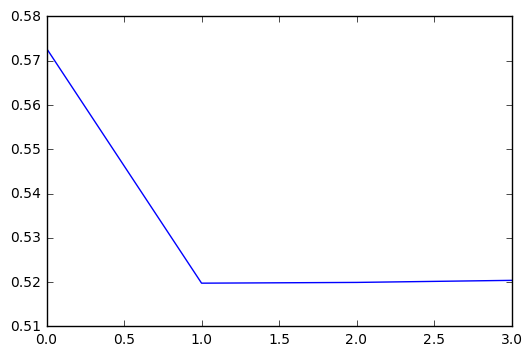

In [7]:
training_losses = train_network(1, num_steps)
plt.plot(training_losses)